# N-grams, Fastttext, and GloVE
# TODO: Introduce AG news dataset


*This assignment focuses on exploring Fasttext and GloVE as NLP methods. We are going to focus on two tasks and ways of understanding models:*

1. *The traditional, "model is a classifier" viewpoint. Here we are going to work with the [AG News Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) to classify genres*
2. *The more vector-based way, seeing them basically as machines that just generate word vectors, with everything else just being gravy. Barring attaching a specific classifier, GloVE falls entirely under this category.* 


Task will be probably be about

- Creating N-gram function (character-wise and word-wise)
- Performing analysis on the output of the pre-made fassttext model
- Training own linear classifier layer of the fasttext model (perhaps too difficult?) - Just create torch.linear, extract weights, etc.
- Perhaps a lot of description about HOW fasttext and Word2Vec skipgram models work?
- Performing PCA and feeding this to Michaels Fasttext model?
- Perhaps crate simple model like naive bayes to classify texts based on PCA and cossim - like final project in 2021, only this time, a lot of the work can be done beforehand



If you want to read more about word2vec, I reccomend: [here first](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/): and: [here afterwards](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)


**TODO: Theoretical Questions**

- Explain a CBOW and Skipgram model
- Fasttext can technically train in only a semi-supervised manner, that means without labeled text, why is this, and why is this useful?
- 

In [8]:
import numpy as np
import scipy
import string
import random
import re
import pickle
import fasttext

import scipy.spatial
import matplotlib.pyplot as plt
# import pylab as plt

from sklearn.decomposition import PCA
from tqdm import tqdm

In [19]:
# Seed generator function
# 
def generate_seed():
    """
    Generates robust seed values using methods adapted from Gaius-quantum reverse...
    ...GaunTLets, see more https://isotropic.org/papers/chicken.pdf and explained https://www.youtube.com/watch?v=dQw4w9WgXcQ
    Values are generated from a specific subset of alphanumerics representing sub-deca natural-numericals
    from the glove.42B.300d.txt Use this subset for the reverse function as well, the whole one will take too long
    """

    with open("important_stuff.pkl", "rb") as fp:
        GQRGaunTLets_69B_300_seed_vals = pickle.load(fp)
        seed = int(np.var(GQRGaunTLets_69B_300_seed_vals[69]) * 100)
        return seed

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    try: torch.manual_seed(seed_value)
    except: pass

seed_everything(generate_seed())

## Exercise 1 Word- and character-wise n-grams

*As you know, n-grams are pretty useful for improving the otherwise limited bag-of-words (BoW) model. Most often, this is by making distinctions between sentences such as "good" and "not good" which would be represented somewhat the same in a regular BoW. It is very obvious if we consider the sentence "Maria stole the milk" vs "The milk stole Maria", two sentences completely identical in the BoW representation, but with two obviously different meanings.*

*As you also know, Fasttext takes this further by creating chracter-wise n-grams. These are made up of n-characters of a single word. This allows fasttext to consider cases such as grammar, where words are spelled similarly and even consider misspellings, if someone makes a mistaek in wirtign a wrod, the character-wise n-gram representation will be **almost** the same as the correct word.*

This is done by Fasttext simply storing embedding vectors $v_n$ for each n-gram, character or otherwise. Fasttext will simply then average all of these vectors, word, character-wise n-grams, and word-wise n-grams to create the representation for a given text or sentence.

$$v_{total} = \frac{1}{N}\sum^N_{n=0} v_n$$

### Important note: Fasttext supervised and unsupervised

*If you look into the technical documentation for the fasttext model, you'll notice that there are options to train both an **unsupervised** and a **supervised** version of the fasttext model. These use similar approaches, but it is arguably the unsupervised model that best describes what the fasttext team wanted to accomplish: efficient word-vector generation for downstream usage.*

***The unsupervised model:***
- *Just needs a corpus of text to train*
- *Does not use wordwise n-grams*
- *Has vectors for each unique character n-gram and each unique word in the corpus (limited by bin size)* 
- *Vectors for character n-grams are created indepedently of word vectors, for example the trigram "her" present in "where" has a different vector representation than the one for the full word "her".*
- *Is a purely skipgram/CBoW model (input layer, one hidden, output layer)*
- *Cannot be directly evaluated except in qualitative ways by considering the downstream tasks it will be used in*

***The supervised model:***
- *Needs a corpus of text with given labels to train*
- *Does not use skipgram/CBoW, but just works as a 'normal' FFN for classification*
- *Uses character-wise n-grams*
- *Uses word-wise n-grams the same way as the unsupervised model uses character-wise n-grams, treating them as vectors and combining them in the end for the final classification.*
- *Can be directly evaluated by just checking how good it is at predicting the given classes.*

***Both models***
- *Only work on CPU (bvadr) (what a time 2015 was!)*

In [3]:
# N-gram functions -  Might need to be filled by students?

def get_n_grams(text, n, lower=True, strip=True):
    """Gets a specific n-gram for a given text string"""
    if lower:
        text = text.lower()
    if strip:
        text = re.sub('[^A-Za-z0-9 ]+', '', text)

    text = text.split()
    n_grams = []

    for i, word in enumerate(text):
        if i+n > len(text):
            break
        n_grams.append(text[i: i+n])

    return n_grams

def get_word_grams(word, n):
    """Gets the character wise n-grams for a single word"""
    word_grams = []

    # So really this is not something you should do for the actual model
    # String concatenation in python is O(N+M) complexity, which is blazingly slow
    # Probably nltk.ngrams function does it faster
    # Fasttext always adds beginning of word and end of word tokens to the words it is n-gramming:
    word = '<' + word + '>'

    for i, character in enumerate(word):
        if i+n > len(word):
            break
        word_grams.append(word[i:i+n])

    return word_grams

*As you can see from running the example below, even in this very small sentence, there are a ton of n-grams, and even more word-grams. This is why, for practical purposes, the Fasttext model often operates on what is known as a **'bucket size'** which defines the maximum number of possible word-grams avaliable in the model.*

In [5]:
# Now let us just test these functions on some toy text...
text = "He turned himself into a pickle... Funniest shit, ive ever seen!!!"

n_grams = get_n_grams(text, n=3, lower=True, strip=True)
word_grams = [get_word_grams(words[0], 3) for words in n_grams]

print("N-grams here: \n ", n_grams)

print("Word-grams here: \n ", word_grams)

N-grams here: 
  [['he', 'turned', 'himself', 'into'], ['turned', 'himself', 'into', 'a'], ['himself', 'into', 'a', 'pickle'], ['into', 'a', 'pickle', 'funniest'], ['a', 'pickle', 'funniest', 'shit'], ['pickle', 'funniest', 'shit', 'ive'], ['funniest', 'shit', 'ive', 'ever'], ['shit', 'ive', 'ever', 'seen']]
Word-grams here: 
  [['<he', 'he>'], ['<tu', 'tur', 'urn', 'rne', 'ned', 'ed>'], ['<hi', 'him', 'ims', 'mse', 'sel', 'elf', 'lf>'], ['<in', 'int', 'nto', 'to>'], ['<a>'], ['<pi', 'pic', 'ick', 'ckl', 'kle', 'le>'], ['<fu', 'fun', 'unn', 'nni', 'nie', 'ies', 'est', 'st>'], ['<sh', 'shi', 'hit', 'it>']]


## 2 Training and using the fasttext model

<p style="text-align:center;">"<i>(Almost) Never do yourself what some other chump has done better"</i> </p>
<p style="text-align:center;"> - Creed of the KID </p>

*Obviously someone else has made a pretty well working [Fasttext module](https://fasttext.cc/). In this case, it is the team at Meta (Facebook, back then). Aside from how well it trains, is does have a few weird things about it, most notably that it requires .txt files to train (bvadr).*

*For this exercise, we are going to focus on just tweaking minn and maxnn whihc control the minimum and maximum length for the character-grams.*

*A complete list of model hyperparameters can be found in the file hypereparams.txt, along with (most) methods callable on the Fasttext model. Refer to this if you need inspiration on making your model interesting.*

*Important note: If the model is asked for a word- or character-vector **not in its current vocabulary**, it will give a zero-vector of the same dimension as the other vectors in its vocabulary. This way even extremely esoteric spelling errors do not 'break' the model due to vocabulary lookup errors, the words themselves will just not add anything to the prediction.*

### Theoretical questions



In [7]:
# Load AG_news data
news_data = np.load('./news_data.npz', allow_pickle=True)
train_texts = news_data['train_texts']
test_texts = news_data['test_texts']
train_labels = news_data['train_labels']
test_labels = news_data['test_labels']
ag_news_labels = news_data['ag_news_label']

print(f"There are a total of {len(train_labels)} data points in the dataset, \n"
        f"{len(test_texts)} different points in the test set, and the different labels are {np.unique(train_labels)},\n"
        f"these correspond to the categories: {ag_news_labels}\n")


# Let's just ensure class proportions are balanced for both training and testing purposes...
n_classes = len(ag_news_labels)
print("Training class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(train_labels==i))
print()

print("Test class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(test_labels==i))


There are a total of 120000 data points in the dataset, 
7600 different points in the test set, and the different labels are [0 1 2 3],
these correspond to the categories: ['World' 'Sports' 'Business' 'Sci/Tec']

Training class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25

Test class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25


# TODO: Add option to not have labels (if we wanna have unsupervised data, for example)

In [25]:
# Creating fasttext data set from current training data
def train_test_split(texts, labels, ag_news_labels, train_split=0.8):
    """
    Creates .txt files for training and testing, compatible with a fasttext model

    Args:
        train_texts (_type_): _description_
        train_labells (_type_): _description_
    """

    text_length = len(texts)

    indices = np.arange(text_length)
    np.random.shuffle(indices)

    texts = texts[indices]
    labels = labels[indices]

    train_size = int(text_length * train_split)

    train_texts = texts[:train_size]
    train_labels = labels[:train_size]

    test_texts = texts[train_size:]
    test_labels = labels[train_size:]

    return train_texts, train_labels, test_texts, test_labels 

def txtify_data(texts, labels, ag_news_labels, save_path):

    txt = ""
    for i, (text, label) in tqdm(enumerate(zip(texts, labels))):
        text = text.lower()
        text = re.sub('[^a-z0-9 ]+', '', text)

        txt = txt + f'__label__{ag_news_labels[label]} {text}\n'

    
    f = open(save_path, mode='w')
    f.write(txt)
    f.close()

    return save_path

path_to_train = txtify_data(train_texts, train_labels, ag_news_labels, save_path='training_data.txt')
path_to_test = txtify_data(test_texts, test_labels, ag_news_labels, save_path='test_data.txt')

120000it [00:00, 126768.57it/s]
7600it [00:00, 133170.31it/s]


In [7]:
# Defining fasttext hyperparameters
char_gram_length_min = 3 # If set to zero, we only train word-grams
char_gram_length_max = 6 # If set to zero, we only train word-grams
num_word_grams = 1 # Default value
verbose = True # Set to false if you don't want to see training statistics

# Train fasttext_word_model and fasttext_char_model respectively
fasttext_word_model = fasttext.train_supervised(path_to_train, maxn=0, minn=0, verbose=verbose,
                                                wordNgrams=num_word_grams)

fasttext_char_model = fasttext.train_supervised(path_to_train, maxn=char_gram_length_max, minn=char_gram_length_min,
                                                verbose=verbose, wordNgrams=num_word_grams)

NameError: name 'path_to_train' is not defined

In [11]:
# Example of how the subwords of the character model and the word model differ
# get_subwords gets all character-gram 'parts' of the word specified...
# ...as well as indices corresponding to the row of the given vector in the embedding matrix
print("Word model subwords:", fasttext_word_model.get_subwords('cat'))
print("Character model subwords:", fasttext_char_model.get_subwords('cat'))

Word model subwords: (['cat'], array([4523]))
Character model subwords: (['cat', '<ca', '<cat', '<cat>', 'cat', 'cat>', 'at>'], array([   4523, 1008044, 2080270, 1519434,  380328, 1219292,  442403]))


In [34]:
def test_prediction(model, test_text, test_label=None, return_bool=True):
    """
    test_labela and return_bool used for when we need accuracy of the model
    Method for testing fasttext model
    Model should be either the character model or the word model
    """
    # Reason why we index the way we do: .predict outputs a tuple of certainty and the label, the label being __label__Business for example for business
    prediction = model.predict(test_text)[0][0][9:]

    if not return_bool:
        return prediction

    if prediction == test_label:
        return True

    return False

text_to_predict = 'A cat in a hat'

prediction = test_prediction(model=fasttext_word_model, test_text=text_to_predict, return_bool=False)

print(f"{text_to_predict}: {prediction}")

A cat in a hat: Sci/Tec


# TODO: MAKE TASK TO REQUIRE THEM TO GET ACCURACY FOR MODEL ON EACH SPECIFIC GENRE!

In [179]:
def test_fasttext_model(fasttext_model, test_texts, test_labels, test_label_names):

    correct_answers = {label: 0 for label in range(len(test_label_names))}

    for text, true_label in zip(test_texts, test_labels):
        correct_answers[true_label] += test_prediction(fasttext_model, text, test_label_names[true_label], return_bool=True)

    for label, value in correct_answers.items():
        print(f"Accuracy of predicting label {test_label_names[label]}: {value / np.sum(test_labels==label)}")

    print(f"Total accuracy of model: {sum(correct_answers.values()) / len(test_labels)}")
    
    return correct_answers

print("Testing fasttext word model...")
test_fasttext_model(fasttext_word_model, test_texts, test_labels, ag_news_labels)

print("\nTesting fasttext character model...")
test_fasttext_model(fasttext_char_model, test_texts, test_labels, ag_news_labels)
print()


Testing fasttext word model...
Accuracy of predicting label World: 0.9068421052631579
Accuracy of predicting label Sports: 0.9657894736842105
Accuracy of predicting label Business: 0.8621052631578947
Accuracy of predicting label Sci/Tec: 0.8942105263157895
Total accuracy of model: 0.9072368421052631

Testing fasttext character model...
Accuracy of predicting label World: 0.9005263157894737
Accuracy of predicting label Sports: 0.9610526315789474
Accuracy of predicting label Business: 0.868421052631579
Accuracy of predicting label Sci/Tec: 0.8752631578947369
Total accuracy of model: 0.9013157894736842



## 3 GloVe to create embeddings vectors

*[GloVe Paper here](https://aclanthology.org/D14-1162.pdf), [GloVe Project page here](https://nlp.stanford.edu/projects/glove/)*

*GloVe is called a "global log-bilinear regression model" which combines the strengths of global matrix factorization and local context window methods.*

*In English, this means it combines methods that work by collecting information on the entire corpus (like LSA), with other methods that capture more local patterns, essentially what we see with Fasttext that considers local n-grams. GloVe just considers "context windows" rather than an n-gram. Overall, what they want are nicely defined, linear relationships, decided by comparing the co-occurences of different words.*

*The selling point really, is that while a run-of-the-mill neural network **may** be able to answer the questions: "Skibidi is to Toilet as Fanum is to ...?", it will not necessarily be able to do it in a linear manner. Therefore considering all the word vectors together in their latent space, may not yield good information. GloVe fixes this by keeping all vector substructures linear.*

*Essentially, GloVe trains by mixing a [Skipgram model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) (just a neural network) with a function that works more on the entire corpus, while maintaining a weighting between the two. Because GloVe works best on huge corpora of data, we are not going to train it ourselves, but just use pretrained GloVe vectors, collected from their [project page](https://nlp.stanford.edu/projects/glove/).* 



### Theoretical questions


**1. GloVe does not use neural networks everywhere, in particular when using F, as it would "obfuscate the linear strcutures they are trying to capture", what linear structures are talked about and how would they be obfuscated?**


**2. Why can we not go the other way when doing embedding vectors? If you had to get a word from a given embedding vector, how would you go about it**

$\dots$

- **2.1 What prevents us from simply making a dictionary with vectors as keys and words as values?**

$\dots$

In [21]:
def load_glove(glove_path):
    """
    Loads a GloVE vectors from a given path
    """
    glove = {}
    
    print("Creating GloVE dictionary...")
    with open(glove_path, 'r') as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            glove[word] = vector
    
    return glove

# TODO: Check if this is actually useful
def create_GloVE_vector(text, glove, dim=300):
    """
    Creates a GloVE vector for a given text and GloVe
    """
    text = text.lower()
    text = re.sub('[^a-z0-9 ]+', '', text)
    text = text.split()

    vector = np.zeros(dim)

    for word in text:
        if word in glove:
            vector += glove[word]

    # TODO: Check if we actually need to get the mean here
    vector = np.mean(vector)
    return vector

# TODO: Check which of these we need

def word_similarity(word1, word2, glove):
    """
    Returns the cosine similarity between two words
    """

    # Sanity check to ensure both words are in GloVE
    if word1 not in glove or word2 not in glove:
        raise ValueError("Both words must be in GloVe!")

    return 1 - scipy.spatial.distance.cosine(glove[word1], glove[word2])

# TODO: CHange variable names
# TODO, JUst have lookup GLove if GloVE is provided, otherwise not
# TODO Have this ues create_glove_vector maybe...
def word_similarity(vec1, vec2, glove, lookup_glove=True):
    if lookup_glove:
        vec1, vec2 = glove[vec1], glove[vec2]
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return (dot_product / (norm_vec1 * norm_vec2))


In [22]:
# Load GloVe dictionary, doing it here since we only wanna do it once, since it takes a fuckton of time
glove = load_glove('glove.42B.300d.txt')

Creating GloVE dictionary...


1917494it [01:26, 22064.60it/s]


In [66]:
word_pairs = [('cat', 'dog'), ('cat', 'banana'), ('cat', 'cat'), ('camera', 'man'), ('steel', 'beams'), ('six', '6')]

for word1, word2 in word_pairs:
    print(f"Similarity between {word1} and {word2} is {word_similarity(word1, word2, glove)}")

Similarity between cat and dog is 0.7885448336601257
Similarity between cat and banana is 0.3027379810810089
Similarity between cat and cat is 1.0000001192092896
Similarity between camera and man is 0.3675020933151245
Similarity between steel and beams is 0.3567618131637573
Similarity between six and 6 is 0.65116947889328


In [ ]:
# words = list(glove.keys())
# embeddings = np.array(list(glove.values()))

# # Step 3: Perform PCA
# pca = PCA(n_components=2)  # Change to 3 for 3D visualization
# reduced_embeddings = pca.fit_transform(embeddings)

# # Step 4: (Optional) Visualize Results
# plt.figure(figsize=(10, 6))
# plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

# # Annotate the points with the corresponding words
# for i, word in enumerate(words):
#     plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

# plt.title('PCA of GloVe Word Embeddings')









# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.grid()
# plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x710b9e03d2e0>>
Traceback (most recent call last):
  File "/home/karl/miniforge3/envs/sign-dat/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


# TODO: Define task about reversing GloVE

## Also have question for why it takes so damn long, and what could be done to amend this

## Extra tasks regarding what part of the task takes hte longest (could this be asynced?)

In [67]:
def find_closest_word(target_vector, glove_lookup):
    max_similarity = -1
    closest_word = None
    for word, vector in glove_lookup.items():
        similarity = word_similarity(target_vector, vector, glove_lookup, lookup_glove=False)
        if similarity > max_similarity:
            max_similarity = similarity
            closest_word = word

    return closest_word

word = 'cat'
word_vector = glove[word]
closest_word = find_closest_word(word_vector, glove)
print("Closest word to given vector is:", closest_word)

cat


## 4 Comparing embeddings vectors

Since both GloVe and Fasttext, at their core, are both methods for egenerating embedding vectors, it would make sense to examine how they look compared to one another. Since both live in high-dimensional spaces, we must perform PCA on them to actually make sense of them in a graphical way.

<!-- We musn't forget, that at its core, fasttext is a method functioning on word embedding vectors, which it obtains by a skipgram model using some clever tricks. As such, we can expect the embeddings that are created by the fasttext model to hold some information about the words they 'code for'. We now wish to perform PCA on the entire word-embedding matrix to see if the semantic difference in words is visible with only a few principal components

 -->


**Explain shortly what you expect to find if we perform PCA on the matrix of word-embeddings, that is the matrix which holds a vector representation of each word in our vocabulary**

*Your answer here*


In [6]:
feats_train = []
feats_test = []

# TODO: Find out what this thing is *actually* doing
def clean(text):
    """
    Cleaning text of non-alphanumerics using the aforementioned string translation table
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower()

def get_average_embeding_vectors(fasttext_model, train_texts, test_texts):
    # Get the average embedding vector for each text in the training set
    for text in tqdm(train_texts):
        words = clean(text).split()
        feats_train.append(np.mean([fasttext_model.get_word_vector(word) for word in words], axis=0))

    # Same but for each text in test set
    for text in tqdm(test_texts):
        words = clean(text).split()
        feats_test.append(np.mean([fasttext_model.get_word_vector(word) for word in words], axis=0))

    return np.arrray(feats_train), np.array(feats_test)

feats_train, feats_test = get_average_embeding_vectors(fasttext_word_model, train_texts, test_texts)

NameError: name 'fasttext_word_model' is not defined

# TODO: add task to also compare it to the fasttext char model

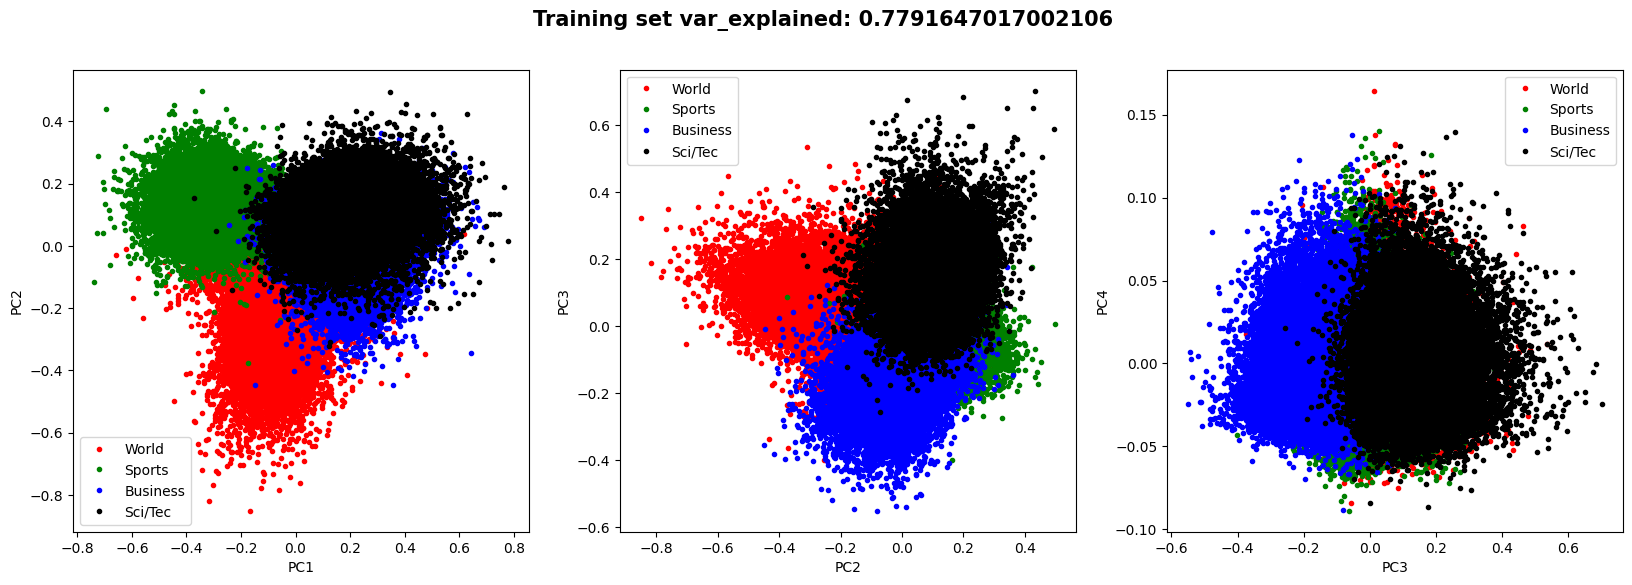

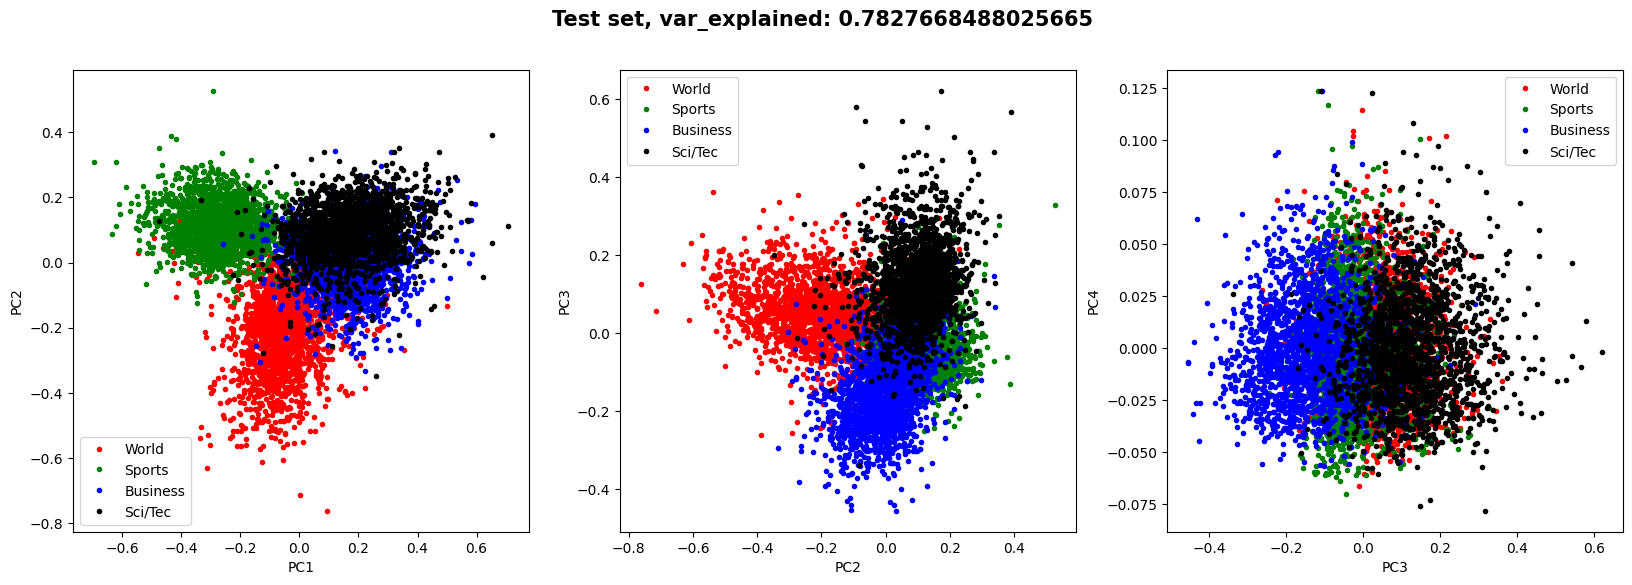

In [90]:
feats_train = feats_train
feats_test = feats_test
train_labels = train_labels
test_labels = test_labels

n_components = 100

pca_word_vec = PCA(n_components=n_components)


# fit_transform avoids having to manually transform the vectors with the matrix afterwards
Vtrain = pca_word_vec.fit_transform(feats_train)
Vtrain_var_explained = pca_word_vec.explained_variance_ratio_

Vtest = pca_word_vec.fit_transform(feats_test)
Vtest_var_explained = pca_word_vec.explained_variance_ratio_

colors = 'rgbk'
for label, transformed_vector, title in zip([train_labels, test_labels], [Vtrain, Vtest], [f'Training set var_explained: {sum(Vtrain_var_explained[:2])}', f'Test set, var_explained: {sum(Vtest_var_explained[:2])}']):

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 0], transformed_vector[label==i, 1], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.subplot(1, 3, 2)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 1], transformed_vector[label==i, 2], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC2')
    plt.ylabel('PC3')

    plt.subplot(1, 3, 3)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 2], transformed_vector[label==i, 3], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC3')
    plt.ylabel('PC4')
    plt.suptitle(title, fontweight='bold', fontsize=15)

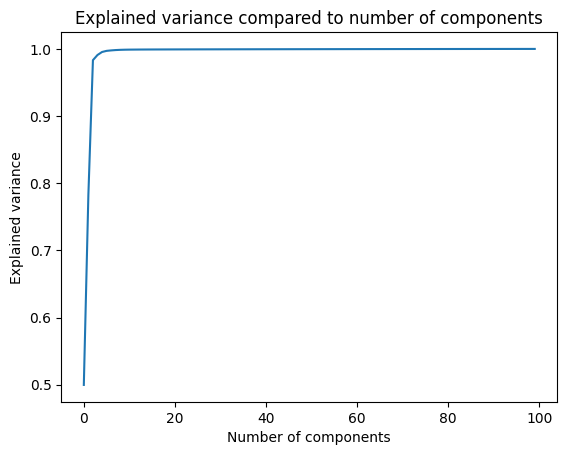

In [78]:
#plt.plot(pca_word_vec.explained_variance_ratio_,"--*");
plt.plot(list(range(n_components)),np.cumsum(pca_word_vec.explained_variance_ratio_))
plt.title("Explained variance compared to number of components")
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

In [158]:

def get_vector_transform(word, model, pca, n=2):
    """
    Should given a specific word string, obtain fasttext's vector representation of that word and project it on the n first principal components
    model should be either your word_model or the character model
    # TODO: ADD WARNING: oNLY WORKS ON SINGLE WORDS AT A TIME
    """

    word_vec = model.get_word_vector(word)
    word_vec = word_vec.reshape(1, -1)
    
    return pca.transform(word_vec)[0, :n]

    # # TODO project word_vec to first n principal components of pca_matrix
    # raise NotImplementedError("Project me like one of your french word vectors")

    # return transformed_vector

# def get_vector_transform(word, model, pca, n=2):
#     """
#     Should given a specific word string, obtain fasttext's vector representation of that word and project it on the n first principal components
#     """
#     word_vec = model.get_word_vector(word)
#     if n == 0:
#         return word_vec
    
#     word_vec = word_vec.reshape(1, -1)

#     return (pca.components_[:n, :] @ word_vec.T).T[0]

# get_vector_transform('cat', fasttext_word_model, pca_word_vec, n=2)

[1.5448397  0.07185517]
[1.0826521  0.14189324]
[0.10297994 0.06716479]
[2.1159103 0.5928923]
[2.19517    0.14802392]
[0.41568857 0.34932357]


Text(0, 0.5, 'Latent Semantic dim 2')

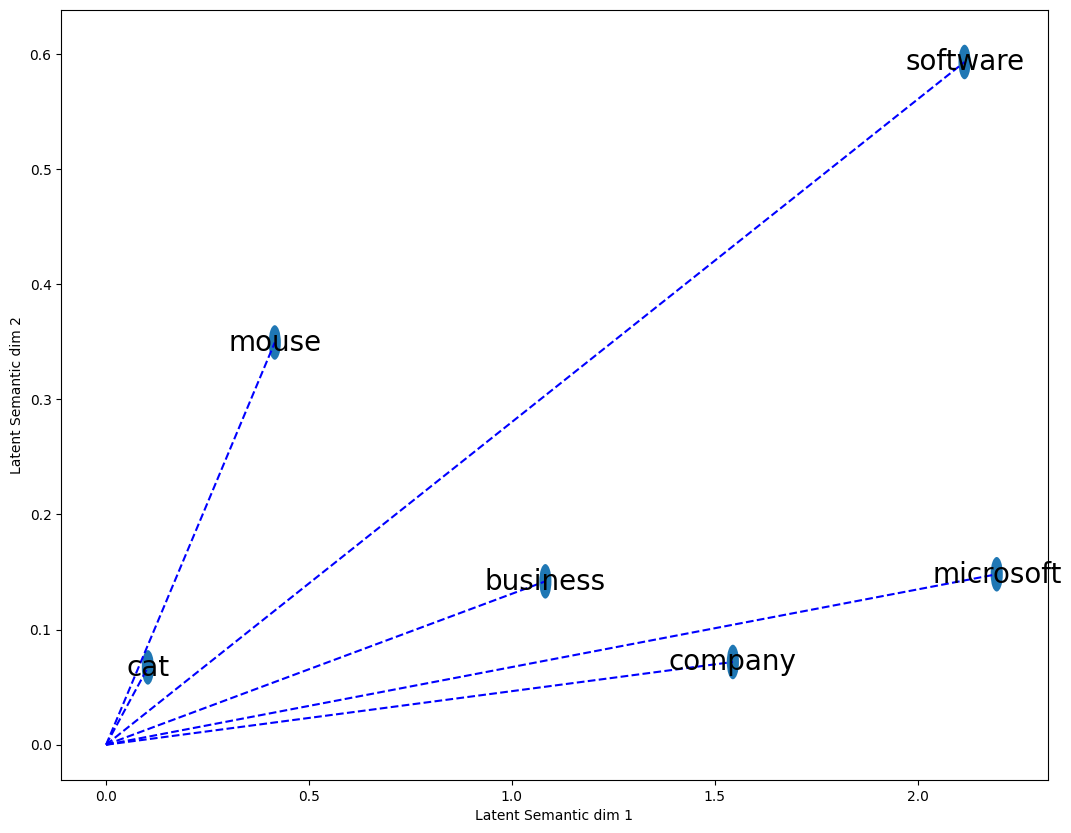

In [159]:
words = ['company', 'business', 'cat', 'software', 'microsoft', 'mouse']
transformed_word_vectors = [get_vector_transform(i, fasttext_word_model, pca_word_vec, n=2) for i in words]
reg_vecs = np.array([fasttext_word_model.get_word_vector(word) for word in words])

plt.figure(figsize=(28, 10))
ax = plt.subplot(1, 2, 1)
for idx, vec in enumerate(transformed_word_vectors):
    print(vec)
    plt.plot([0, vec[0]], [0, vec[1]], 'b--')
    circle = plt.Circle((vec[0], vec[1]), radius=0.015)
    ax.add_patch(circle)
    label = ax.annotate(words[idx], xy=(vec[0], vec[1]), fontsize=20, ha="center", va="center")

plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')

In [167]:

import scipy.spatial
n = 2 # Number of principal components to do with
to_compare = ['software', 'business', 'world'] # Three words, that should be labeled as three different things
for word in words:
    for comparison in to_compare:
        distance = word_similarity(
                                    vec1=get_vector_transform(word, fasttext_word_model, pca_word_vec, n=n),
                                    vec2=get_vector_transform(comparison, fasttext_word_model, pca_word_vec,n=n),
                                    glove=None, lookup_glove=False
                                    )
        print(f"{word}-{comparison}: {distance}")
    print()

company-software: 0.9744086861610413
company-business: 0.996487557888031
company-world: -0.5447800755500793

business-software: 0.9898096323013306
business-business: 1.0
business-world: -0.47264382243156433

cat-software: 0.9539284110069275
cat-business: 0.9014837145805359
cat-world: -0.04466266557574272

software-software: 1.0000001192092896
software-business: 0.9898096323013306
software-world: -0.34233981370925903

microsoft-software: 0.9788833260536194
microsoft-business: 0.9980168342590332
microsoft-world: -0.5271784663200378

mouse-software: 0.910764753818512
mouse-business: 0.8426843881607056
mouse-world: 0.07618420571088791



## Another strength of fasttext: Spelling errors

A good thing if we want to use fasttext on a character level, is that it will be able to understand spelling errors. We're going to test this now by replacing a bunch of letters in our test set randomly with other words and once more test the accuracy of the word-wise fasttext vs the character-wise fasttext

In [168]:
def dyslexibot(test_set: list, p=0.05, extra_scuffed=False):
    """
    tHe AlMiGhTy dyslexibot(tm) replaces letters with probability p
    extra_scuffed does what it says: it makes the replacements even harder to guess
    This function is pretty ineffective, if you want to spruce it up, you are welcome to do so
    """

    if extra_scuffed:
        test_set_letters = np.array(list(set(''.join(test_texts)))) # Can replace with all letters currently in test set
    else:
        test_set_letters = np.array(list(string.ascii_lowercase)) # Can only replace with lowercase letters

    new_test_set = [text.split(' ') for text in test_set.copy()]

    print("Replacing text")
    for i, text in tqdm(enumerate(new_test_set)):
        for r, word in enumerate(text):
            word = list(word)
            for t, letter in enumerate(word):
                rand = random.uniform(0, 1)

                if extra_scuffed and rand < p: # We replace even spaces!
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

                elif letter != ' ' and rand < p:
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

            text[r] = ''.join(word)
        new_test_set[i] = ' '.join(text)
    return np.array(new_test_set)

In [170]:
# Showing that dyslexibot works
text = ["have you heard of the tragedy of darth plagueis the wise"]
print(dyslexibot(text, p=0.10, extra_scuffed=False))

Replacing text


1it [00:00, 3813.00it/s]

['nave iou heard of the tlagedz df uarth plagueic tge lise']


# TODO: ADD TASK TO TEST BOTH MODELS FOR A FEW VALUES OF P AND WITH EXTRA_SCUFFED OR NOT!!

In [180]:
dyslexitext = dyslexibot(test_texts, p=0.20, extra_scuffed=False)

# Insert your training loop here to calculate the test accuracy on the dyslexitext
# using both the word-wise fasttext and the character-wise fasttext


print("Testing fasttext word model...")
test_fasttext_model(fasttext_word_model, dyslexitext, test_labels, ag_news_labels)

print("\nTesting fasttext character model...")
test_fasttext_model(fasttext_char_model, dyslexitext, test_labels, ag_news_labels)
print()


# # TODO: What it says one line above
# ???????????
# ???????????
# ???????????
# raise NotImplementedError("Test me")

Replacing text


7600it [00:02, 2961.39it/s]


Testing fasttext word model...
Accuracy of predicting label World: 0.7931578947368421
Accuracy of predicting label Sports: 0.6968421052631579
Accuracy of predicting label Business: 0.7015789473684211
Accuracy of predicting label Sci/Tec: 0.7621052631578947
Total accuracy of model: 0.738421052631579

Testing fasttext character model...
Accuracy of predicting label World: 0.8857894736842106
Accuracy of predicting label Sports: 0.868421052631579
Accuracy of predicting label Business: 0.7894736842105263
Accuracy of predicting label Sci/Tec: 0.828421052631579
Total accuracy of model: 0.8430263157894737



# 5 Custom text classification

Finally, to show the robustness of fasttext (and for fun), you are to make your own text and try to let fasttext classify this as one of the four models. Rememeber that the original dataset used texts of around 240 words, so you can either experiment with texts shorter or longer than this and see whether the accuracy is significantly different.

As an extra challenge, you can try to create a text which is as close to the model's decision boundary as possible, IE. one that is as close as possible to being classified as either two or more of the classes

In [189]:
own_text = ""

assert own_text != "", "Come on, be creative"

print("The text is classified as: ", fasttext_word_model.predict(own_text))#[0][0][9:])

AssertionError: Come on, be creative

## 6 Extremely optional task

It's quite a waste to have all those juicy principle components of the embedding matrices without using them in a classifier of some sort, right?

Create a classifier to classify texts as one of the four labels, based on the projections of their words unto a number of the principle components of the embedding matrices. Compare this classifier to the fasttext classifier and reflect on their performance.

raise NotImplementedError("Asking for a whole classifier is a bit much, no?")

In [ ]:
raise NotImplementedError("Asking for a whole classifier is a bit much, no?")

In [ ]:
"""
$ ./fasttext supervised
Empty input or output path.

The following arguments are mandatory:
  -input              training file path
  -output             output file path

  The following arguments are optional:
  -verbose            verbosity level [2]

  The following arguments for the dictionary are optional:
  -minCount           minimal number of word occurrences [1]
  -minCountLabel      minimal number of label occurrences [0]
  -wordNgrams         max length of word ngram [1]
  -bucket             number of buckets [2000000]
  -minn               min length of char ngram [0]
  -maxn               max length of char ngram [0]
  -t                  sampling threshold [0.0001]
  -label              labels prefix [__label__]

  The following arguments for training are optional:
  -lr                 learning rate [0.1]
  -lrUpdateRate       change the rate of updates for the learning rate [100]
  -dim                size of word vectors [100]
  -ws                 size of the context window [5]
  -epoch              number of epochs [5]
  -neg                number of negatives sampled [5]
  -loss               loss function {ns, hs, softmax} [softmax]
  -thread             number of threads [12]
  -pretrainedVectors  pretrained word vectors for supervised learning []
  -saveOutput         whether output params should be saved [0]

  The following arguments for quantization are optional:
  -cutoff             number of words and ngrams to retain [0]
  -retrain            finetune embeddings if a cutoff is applied [0]
  -qnorm              quantizing the norm separately [0]
  -qout               quantizing the classifier [0]
  -dsub               size of each sub-vector [2]
"""

"""
https://fasttext.cc/docs/en/python-module.html
    get_dimension           # Get the dimension (size) of a lookup vector (hidden layer).
                            # This is equivalent to `dim` property.
    get_input_vector        # Given an index, get the corresponding vector of the Input Matrix.
    get_input_matrix        # Get a copy of the full input matrix of a Model.
    get_labels              # Get the entire list of labels of the dictionary
                            # This is equivalent to `labels` property.
    get_line                # Split a line of text into words and labels.
    get_output_matrix       # Get a copy of the full output matrix of a Model.
    get_sentence_vector     # Given a string, get a single vector represenation. This function
                            # assumes to be given a single line of text. We split words on
                            # whitespace (space, newline, tab, vertical tab) and the control
                            # characters carriage return, formfeed and the null character.
    get_subword_id          # Given a subword, return the index (within input matrix) it hashes to.
    get_subwords            # Given a word, get the subwords and their indicies.
    get_word_id             # Given a word, get the word id within the dictionary.
    get_word_vector         # Get the vector representation of word.
    get_words               # Get the entire list of words of the dictionary
                            # This is equivalent to `words` property.
    is_quantized            # whether the model has been quantized
    predict                 # Given a string, get a list of labels and a list of corresponding probabilities.
    quantize                # Quantize the model reducing the size of the model and it's memory footprint.
    save_model              # Save the model to the given path
    test                    # Evaluate supervised model using file given by path
    test_label              # Return the precision and recall score for each label.

    model.words         # equivalent to model.get_words()
    model.labels        # equivalent to model.get_labels()
"""


""""

# Not really necessary to load data since train_supervised works directly off of a .txt file
#data = np.load(os.getcwd() + 'news_data.npz')

# Training is usually really fast
print("Training model")
model = fasttext.train_supervised(input="dat_data_new_labels_cleaned.txt", verbose=False, maxn=3, minn=3)

mat = model.get_input_matrix()
words = model.get_words()

print("Mat is here")
print(mat.shape)

print("Word length is")
print(len(words))
"""
"""

# Quickly cobbled-together test-set creator
print("Creating test set")
txt = open('dat_data_new_labels_cleaned.txt', 'r')
txt_arr = txt.read().split('\n')

tests = []
labels = []
for r, i in enumerate(txt_arr):
    to_append = i.split(' ', 1)
    tests.append(to_append[1])
    labels.append(to_append[0])


print('Predicting')
su = 0
for i, test in enumerate(tests):
    predict_label = model.predict(test)[0][0]

    if predict_label == labels[i]:
        su += 1

print("Total accuracy was ", su/len(tests))
"""
#print()


# Next we'll try to obtain the vector representations of some simple words

words = ['company', 'business', 'cat', 'software', 'microsoft']
word_vectors = np.array([fasttext_model.get_word_vector(word) for word in words])
print(word_vectors.shape)
n = 2 # Number of principal components
transformed_vectors = pca.components_[:n]@word_vectors.T
transformed_vectors = transformed_vectors.T


import numpy as np
import matplotlib.pyplot as plt

origin = np.zeros((2,6)) # origin point


print(transformed_vectors.shape)
print(transformed_vectors)
origin = np.zeros((2,6))

max_dim = np.amax(abs(transformed_vectors))


plt.quiver(np.zeros(6), np.zeros(6), transformed_vectors[:,0], transformed_vectors[:,1], angles='xy', scale_units='xy', color=['r','b','g', 'pink', 'cyan'])
plt.legend([word for word in words])
plt.grid(b=True, which='major') #<-- plot grid lines
plt.xlim([-max_dim, max_dim]) #<-- set the x axis limits
plt.ylim([-max_dim,max_dim]) #<-- set the y axis limits
plt.show()
